In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
NUM_CLASSES = 9
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
DATA_DIR = "/Users/mohitredhu/Desktop/Study/skin_diseases_predictor/dataset"  # Ensure this folder exists in your project

# Check if dataset directories exist
train_dir = os.path.join(DATA_DIR, "train")
val_dir = os.path.join(DATA_DIR, "val")

if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    raise FileNotFoundError("Dataset directories not found! Check your dataset folder structure.")

# Image Data Generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load Training Data
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

# Load Validation Data
val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

# Check class names
print(f"Class labels: {train_ds.class_indices}")

Found 6231 images belonging to 9 classes.
Found 1664 images belonging to 9 classes.
Class labels: {'Acne and Rosacea Photos': 0, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1, 'Atopic Dermatitis Photos': 2, 'Exanthems and Drug Eruptions': 3, 'Hair Loss Photos Alopecia and other Hair Diseases': 4, 'Herpes HPV and other STDs Photos': 5, 'Nail Fungus and other Nail Disease': 6, 'Poison Ivy Photos and other Contact Dermatitis': 7, 'Psoriasis pictures Lichen Planus and related diseases': 8}


In [4]:
import tensorflow as tf

# Define CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # First Convolutional Block (SeparableConv2D for faster computation)
    tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.MaxPooling2D(),

    # Second Convolutional Block
    tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    # Third Convolutional Block
    tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

     # forth Convolutional Block
    tf.keras.layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    # Global Average Pooling
    tf.keras.layers.GlobalAveragePooling2D(),

    # Fully Connected Layers with Dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),  # Prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile Model with Learning Rate Scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Reduce learning rate if validation loss plateaus
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Show model summary
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-04-23 19:19:48.347618: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-23 19:19:48.348074: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-23 19:19:48.348106: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-23 19:19:48.348454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 19:19:48.348545: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 180, 180, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 180, 180, 32)   │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 90, 90, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 90, 90, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 45, 45, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 22, 22, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,204 (575.02 KB)

 Trainable params: 146,436 (572.02 KB)

 Non-trainable params: 768 (3.00 KB)

In [6]:
# Define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)

# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
    ,
    callbacks=[early_stop]
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 110s 562ms/step - accuracy: 0.2475 - loss: 2.5643 - val_accuracy: 0.1707 - val_loss: 2.1003
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 107s 547ms/step - accuracy: 0.2671 - loss: 2.6512 - val_accuracy: 0.2674 - val_loss: 2.1324
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 103s 528ms/step - accuracy: 0.2866 - loss: 2.5503 - val_accuracy: 0.1779 - val_loss: 4.0854
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 103s 530ms/step - accuracy: 0.2983 - loss: 2.2589 - val_accuracy: 0.2434 - val_loss: 2.4250
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 104s 534ms/step - accuracy: 0.3290 - loss: 2.0616 - val_accuracy: 0.3107 - val_loss: 2.0905
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 146s 747ms/step - accuracy: 0.3562 - loss: 1.9549 - val_accuracy: 0.3942 - val_loss: 1.7484
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 117s 599ms/step - accuracy: 0.3684 - loss: 1.8968 - val_accuracy: 0.2969 - val_loss: 2.2732
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 539ms/step - accuracy: 0.3769 -

In [7]:
# Evaluate the model
loss, acc = model.evaluate(val_ds, batch_size=BATCH_SIZE)
print(f"Validation Accuracy: {round(acc, 2)}")
print(f"Validation Loss: {round(loss, 2)}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.4234 - loss: 1.9255
Validation Accuracy: 0.43
Validation Loss: 1.87


In [7]:
p

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


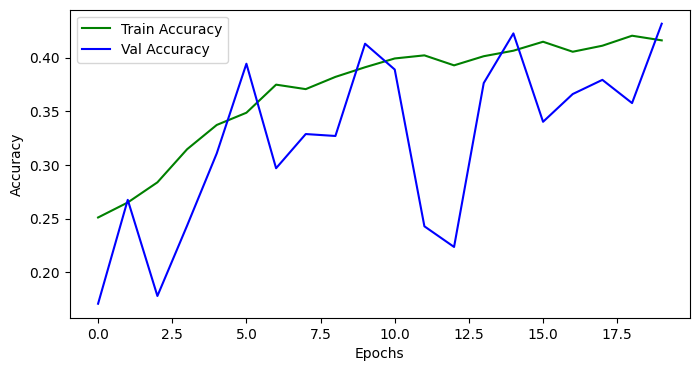

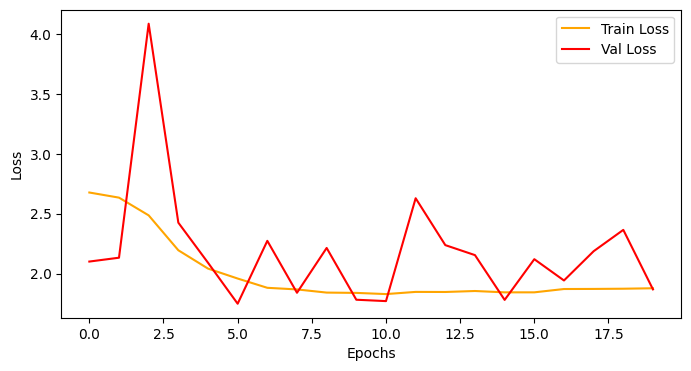

In [8]:
# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
import tensorflow as tf

model.save("model_v1.h5")
print("✅ Model re-saved successfully!")

✅ Model re-saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━

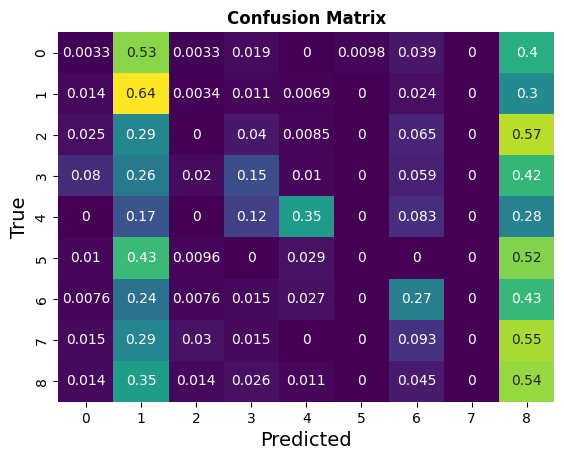

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels & predictions
y_true = []
y_pred = []

# Limit the loop to 20 iterations
# i = 0
for image_batch, label_batch in val_ds:
    # if i >= 20:
        # break  # Stop after 20 iterations

    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis=-1))
    
    # i += 1  # Increment counter

# Convert to tensor
correct_labels = np.concatenate(y_true)
predicted_labels = np.concatenate(y_pred)

# Confusion Matrix
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=False)
plt.title("Confusion Matrix", fontweight='bold')
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

In [11]:
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


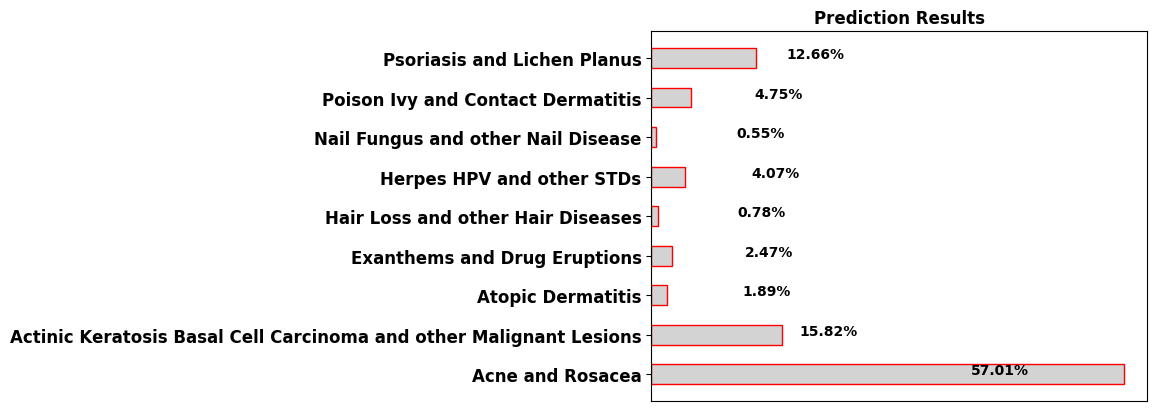

In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(img_path):
    class_names = [
        'Acne and Rosacea', 
        'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 
        'Atopic Dermatitis', 
        'Exanthems and Drug Eruptions', 
        'Hair Loss and other Hair Diseases', 
        'Herpes HPV and other STDs', 
        'Nail Fungus and other Nail Disease', 
        'Poison Ivy and Contact Dermatitis', 
        'Psoriasis and Lichen Planus'
    ]

    # Load image
    my_image = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0) / 255.0

    # Make Prediction
    out = model.predict(my_image)[0]

    # Plot results
    plt.barh(class_names, out, color='lightgray', edgecolor='red', linewidth=1, height=0.5)
    for index, value in enumerate(out):
        plt.text(value / 2 + 0.1, index, f"{100 * value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks(range(len(class_names)), labels=class_names, fontweight='bold', fontsize=12)
    plt.title("Prediction Results", fontweight='bold')
    plt.show()

# Test the function
img = "/Users/mohitredhu/Desktop/Study/skin_diseases_predictor/dataset/val/Acne and Rosacea Photos/08PerioralDerm1.jpg" # Change this to the path of a test image
predict_image(img)